In [43]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 26 23:09:38 2020
https://github.com/jenhuluck/Deep-Learning-in-Human-Activity-Recognition-/blob/master/Opportunity/OpportunityUCIDataset/dataProcessing.py
@author: Jieyun Hu
"""

# This file is for PAMAP2 data processing
import warnings
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import h5py
import os 
directory = 'datasets/OpportunityUCIDataset/'
columns_name = 'dataset/column_names.txt'
columns_name = os.path.join(directory, columns_name)
activities = {1: 'stand',
              2: 'walk',
              4: 'sit',
              5: 'lie',
              101: 'relaxing',
              102: 'coffee time',
              103: 'early morning',
              104: 'cleanup',
              105: 'sandwich time'
               }

def read_files():
    #pick partial data from dataset
    list_of_files = ['dataset/S1-ADL1.dat',
                     'dataset/S1-ADL2.dat',
                     'dataset/S1-ADL3.dat',
                     'dataset/S1-ADL4.dat',
                     'dataset/S2-ADL1.dat',
                     'dataset/S2-ADL2.dat',
                     'dataset/S2-ADL3.dat',
                     'dataset/S2-ADL4.dat',
                     'dataset/S3-ADL1.dat',
                     'dataset/S3-ADL2.dat',
                     'dataset/S3-ADL3.dat',
                     'dataset/S3-ADL4.dat',
                     'dataset/S4-ADL1.dat',
                     'dataset/S4-ADL2.dat',
                     'dataset/S4-ADL3.dat',
                     'dataset/S4-ADL4.dat',                 
                     ]
    
    list_of_drill = ['dataset/S1-Drill.dat',
                     'dataset/S2-Drill.dat',
                     'dataset/S3-Drill.dat',
                     'dataset/S4-Drill.dat',
                     ]
    col_names = []
    with open(columns_name,'r') as f:# a file with all column names was created
        lines = f.read().splitlines()
        for line in lines:
            if line.startswith('Column:'):
                line = line.split(' ')
                lis = line[2::]
                if len(lis) == 1:
                    line = lis[0]
                else:
                    line = '_'.join(lis[0:3]).strip().strip(';').strip('\n')
                col_names.append(line)
    print(col_names)

    toDrop = []
    for each in col_names:
        for other_name in ['MILLISEC', 'LL_Left_Arm','LL_Left_Arm_Object','LL_Right_Arm','LL_Right_Arm_Object']:
            if other_name in each:
                toDrop.append(each)
        #['MILLISEC', 'LL_Left_Arm','LL_Left_Arm_Object','LL_Right_Arm','LL_Right_Arm_Object', 'ML_Both_Arms']:
            

    dataCollection = pd.DataFrame()
    for i, file in enumerate(list_of_drill):
        print(file," is reading...")
        file = os.path.join(directory, file)
        procData = pd.read_table(file, header=None, sep='\s+')
        # print(procData.columns)
        print('procData', procData.shape, type(procData), set(procData[244]))
        procData.columns = col_names
        procData['file_index'] = i # put the file index at the end of the row
        warnings.filterwarnings("ignore")
        dataCollection = dataCollection.append(procData, ignore_index=True)   
        warnings.filterwarnings("default")    
        #break; # for testing short version, need to delete later       
    dataCollection.reset_index(drop=True, inplace=True)
    
    return dataCollection, toDrop


def dataCleaning(dataCollection, toDrop):
    # check if there is missing data:
    # print('checking if there is missing data', dataCollection.isna().sum().sum())#count all NaN
    dataCollection = dataCollection.loc[:,dataCollection.isnull().mean()< 0.1] #drop the columns which has NaN over 10%
    #print(list(dataCollection.columns.values))
    print('dropped data', len(toDrop))
    dataCollection = dataCollection.drop(toDrop,
                                        axis = 1)  # removal of columns not related, may include others.
    
    dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells
    
    print('count NaN', dataCollection.isna().sum().sum())#count all NaN 
    print(dataCollection.shape)
    #dataCollection = dataCollection.dropna()
    dataCollection = dataCollection.interpolate() 
    print(dataCollection.isna().sum().sum())#count all NaN 
    #removal of any remaining NaN value cells by constructing new data points in known set of data points
    #for i in range(0,4):
    #    dataCollection["heartrate"].iloc[i]=100 # only 4 cells are Nan value, change them manually
    print("data cleaned!")
    return dataCollection

def reset_label(dataCollection, locomotion): 
    # Convert original labels {1, 2, 4, 5, 101, 102, 103, 104, 105} to new labels. 
    # mapping = {1:1, 2:2, 5:0, 4:3, 101: 0, 102:1, 103:2, 104:3, 105:4} # old activity id to new activity Id 
    mapping = {406516: 0,
                406517: 1,
                404516: 2,
                404517: 3,
                406520: 4,
                404520: 5,
                406505: 6,
                404505: 7,
                406519: 8,
                404519: 9,
                406511: 10,
                404511: 11,
                406508: 12,
                404508: 13,
                408512: 14,
                407521: 15,
                405506 : 16,}

    if locomotion: #new labels [0,1,2,3]
        for i in [5,4]: # reset ids in Locomotion column
            dataCollection.loc[dataCollection.Locomotion == i, 'Locomotion'] = mapping[i]
    else: # reset the high level activities ; new labels [0,1,2,3,4]
        for j in [406516, 406517, 404516, 404517, 406520, 404520, 406505, 404505, 406519, 404519, 406511, 404511, 406508, 404508, 408512, 407521, 405506]:
            print('what is j', j)
            dataCollection.loc[dataCollection.HL_Activity == j, 'HL_Activity'] = mapping[j]
    return dataCollection

def segment_locomotion(dataCollection, window_size): # segment the data and create a dataset with locomotion classes as labels
    #remove locomotions with 0
    dataCollection = dataCollection.drop(dataCollection[dataCollection.Locomotion == 0].index)
    # reset labels
    dataCollection= reset_label(dataCollection,True)
    #print(dataCollection.columns)
    loco_i = dataCollection.columns.get_loc("Locomotion")
    #convert the data frame to numpy array
    data = dataCollection.to_numpy()
    #segment the data
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][loco_i] == data[end][loco_i] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the file
            X.append(data[start:(end+1),0:loco_i])
            y.append(data[start][loco_i])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][loco_i] != data[start+1][loco_i]:
                    break
                start += 1
            start += 1
    print(np.asarray(X).shape, np.asarray(y).shape)
    return {'inputs' : np.asarray(X), 'labels': np.asarray(y,dtype=int)}

def segment_high_level(dataCollection, window_size): # segment the data and create a dataset with high level activities as labels
    #remove locomotions with 0
    dataCollection = dataCollection.drop(dataCollection[dataCollection.ML_Both_Arms == 0].index)
    # reset labels
    dataCollection= reset_label(dataCollection,False)
    #print(dataCollection.columns)
    HL_Activity_i = dataCollection.columns.get_loc("ML_Both_Arms")
    #convert the data frame to numpy array
    data = dataCollection.to_numpy()
    #segment the data
    n = len(data)
    return dataCollection

def plot_series(df, colname, act, file_index, start, end):
    unit='ms^-2'
    #pylim =(-25,25)
    #print(df.head())
    print(set(df.loc[df.file_index == file_index, "Locomotion"]))
    df1 = df[(df.Locomotion == act) & (df.file_index == file_index)]
    #df1 = df[(df.HL_Activity ==act) & (df.file_index == file_index)]
    if df1.shape[0] < 1:
        print("Didn't find the region. Please reset activityID and subject_id")
        return
    df_len = df1.shape[0]
    if df_len > start and df_len  > end:
        df1 = df1[start:end]
    elif df_len  > start and df_len  <= end:
        df1 = df1[start:df_len]
    else:
        print("Out of boundary, please reset the start and end points")
        return
    print(df1.shape)
    #print(df1.head(10))
    plottitle = colname +' - ' + str(act)
    #plotx = colname
    fig = df1[colname].plot()
    #print(df.index)
    #ax1 = df1.plot(x=df.index,y=plotx, color='r', figsize=(12,5), ylim=pylim)
    fig.set_title(plottitle)
    fig.set_xlabel('window')
    fig.set_ylabel(unit)
    

def save_data(data,file_name): # save the data in h5 format
    f = h5py.File(file_name,'w')
    for key in data:
        print(key)
        f.create_dataset(key,data = data[key])       
    f.close()
    print('Done.')    


window_size = 50   
df, toDrop = read_files()
# print(len(toDrop))
df = dataCleaning(df, toDrop)
#plot_series(df, colname, act, file_index, start, end)
# only keep these ['InertialMeasurementUnit_RLA_accX', '_accY', 'InertialMeasurementUnit_RLA_accZ', 'InertialMeasurementUnit_RLA_gyroX', 'InertialMeasurementUnit_RLA_gyroY']
# plot_series(df, "Accelerometer_RKN^_accX", 4, 2, 0, 500)
# check if InertialMeasurementUnit RLA accX is in df:


# i want to keep columns that starts with InertialMeasurementUnit_RLA and the col of HL_Activitiy and locomotion as one df
df_imu = df[['InertialMeasurementUnit_RLA_accX', 'InertialMeasurementUnit_RLA_accY','InertialMeasurementUnit_RLA_accZ', 
            'InertialMeasurementUnit_RLA_gyroX', 'InertialMeasurementUnit_RLA_gyroY', 'InertialMeasurementUnit_RLA_gyroZ',   'HL_Activity', 'ML_Both_Arms', 'file_index']]


# print(df_imu)

print(set(df_imu['HL_Activity']))
# hl_filename = "hl_2.h5" #"hl.h5" is to save high level dataset
# data_hl = segment_high_level(df_imu, window_size)
# save_data(data_hl,hl_filename)

    
    
    
    
    
    

    
    

<>:81: DeprecationWarning: invalid escape sequence \s
<>:81: DeprecationWarning: invalid escape sequence \s
/var/folders/9s/zgph6l3n6b75g5pycfr4d_n40000gn/T/ipykernel_44578/1335163756.py:81: DeprecationWarning: invalid escape sequence \s
  procData = pd.read_table(file, header=None, sep='\s+')


['MILLISEC', 'Accelerometer_RKN^_accX', 'Accelerometer_RKN^_accY', 'Accelerometer_RKN^_accZ', 'Accelerometer_HIP_accX', 'Accelerometer_HIP_accY', 'Accelerometer_HIP_accZ', 'Accelerometer_LUA^_accX', 'Accelerometer_LUA^_accY', 'Accelerometer_LUA^_accZ', 'Accelerometer_RUA__accX', 'Accelerometer_RUA__accY', 'Accelerometer_RUA__accZ', 'Accelerometer_LH_accX', 'Accelerometer_LH_accY', 'Accelerometer_LH_accZ', 'Accelerometer_BACK_accX', 'Accelerometer_BACK_accY', 'Accelerometer_BACK_accZ', 'Accelerometer_RKN__accX', 'Accelerometer_RKN__accY', 'Accelerometer_RKN__accZ', 'Accelerometer_RWR_accX', 'Accelerometer_RWR_accY', 'Accelerometer_RWR_accZ', 'Accelerometer_RUA^_accX', 'Accelerometer_RUA^_accY', 'Accelerometer_RUA^_accZ', 'Accelerometer_LUA__accX', 'Accelerometer_LUA__accY', 'Accelerometer_LUA__accZ', 'Accelerometer_LWR_accX', 'Accelerometer_LWR_accY', 'Accelerometer_LWR_accZ', 'Accelerometer_RH_accX', 'Accelerometer_RH_accY', 'Accelerometer_RH_accZ', 'InertialMeasurementUnit_BACK_accX',

In [2]:
# count the row that has nan:
df_imu[df_imu.ML_Both_Arms == 406516]

,InertialMeasurementUnit_RLA_accX,InertialMeasurementUnit_RLA_accY,InertialMeasurementUnit_RLA_accZ,InertialMeasurementUnit_RLA_gyroX,InertialMeasurementUnit_RLA_gyroY,InertialMeasurementUnit_RLA_gyroZ,HL_Activity,ML_Both_Arms,file_index
2818,-753.0,679.0,170.0,694.0,-812.0,1283.0,0,406516,0
2819,-704.0,803.0,251.0,420.0,-736.0,1468.0,0,406516,0
2820,-661.0,1036.0,366.0,-113.0,-857.0,1860.0,0,406516,0
2821,-704.0,1027.0,417.0,-515.0,-1080.0,2192.0,0,406516,0
2822,-575.0,921.0,499.0,81.0,-1443.0,2357.0,0,406516,0
...,...,...,...,...,...,...,...,...,...
222287,11.0,880.0,635.0,-1243.0,-449.0,-3120.0,0,406516,3
222288,-65.0,719.0,741.0,-1854.0,-182.0,-3140.0,0,406516,3
222289,-190.0,559.0,810.0,-1458.0,25.0,-3253.0,0,406516,3
222290,-400.0,438.0,885.0,-558.0,111.0,-3546.0,0,406516,3


<Axes: >

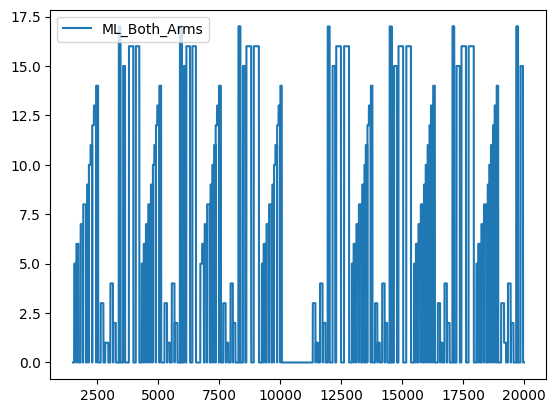

In [3]:
# convert the units:
# InertialMeasurementUnit RLA accX [value = round(original_value / 9.8 * 1000), unit = milli g,] convert to g:
# InertialMeasurementUnit RLA gyroX [ value = round(original_value * 1000), unit = unknown]
import pandas as pd
import numpy as np

# Function to convert gyroscope data
def convert_gyro_to_radians(df):
    # Constants for conversion
    scale_factor = 1000.0
    degrees_to_radians = np.pi / 180
    
    # Copy the DataFrame to avoid modifying the original data
    converted_df = df.copy()
    
    # Convert columns 3, 4, and 5
    for col in [3, 4, 5]:
        # Undo the scaling by dividing by 1000 and convert to radians per second
        converted_df.iloc[:, col] = (converted_df.iloc[:, col] / scale_factor) * degrees_to_radians
    
    return converted_df
def convert_accel_to_g(df):
    # Constants for conversion
    scale_factor = 1000.0  # To convert from milli-g to g

    # Copy the DataFrame to avoid modifying the original data
    converted_df = df.copy()
    
    # Convert columns 0, 1, and 2
    for col in [0, 1, 2]:
        # Divide by 1000 to convert from milli-g to g
        converted_df.iloc[:, col] = converted_df.iloc[:, col] / scale_factor
    
    return converted_df
# map the ML_both_hand:
mapping = {0: 0,
    406516: 1,
                406517: 2,
                404516: 3,
                404517: 4,
                406520: 5,
                404520: 6,
                406505: 7,
                404505: 8,
                406519: 9,
                404519: 10,
                406511: 11,
                404511: 12,
                406508: 13,
                404508: 14,
                408512: 15,
                407521: 16,
                405506 : 17,}

df_imu_conv = df_imu.copy()
df_imu_conv['ML_Both_Arms'] = df_imu['ML_Both_Arms'].map(mapping)

# Convert the data
converted_df = convert_gyro_to_radians(df_imu_conv)
converted_df = convert_accel_to_g(converted_df)

# converted_df[1500: 4000][df_imu.columns[[3,4,5]]].plot()

converted_df[1500: 20000][df_imu.columns[[7]]].plot()

In [103]:
# split by exercise and split by file (which is subject)
# give a repetition id to each exercise when the file changes (reset the id to 0); 
# repetition id +=1 when it reachs to the same exercises again (if it is different exercises id dont change)

# for subject_id in range(0, 4):
#     # by 'subject'
#     cur_user_df = converted_df.loc[converted_df.file_index == subject_id] 
#     for index, row in cur_user_df.items():
#         # ax, ay, az, gx, gy, gz, _, label, _ = row
#         print(row)
#         break
#     break
# cur_subject = -1
# cur_label = -1
# repetition_id = 0
# save_data = []
# for index, row in converted_df.iterrows():
#     ax, ay, az, gx, gy, gz, _, label, subject_id = row
#     if cur_subject != subject_id:
#         cur_subject = subject_id
#     else:
#         if label == 0:
#             pass 
#             # dont worry about it
#         if label == cur_label:
#             save_data.append(row)
#             repetition_id += 1

#NOTE: MIGHT HAVE PROBLEM DOING THIS WITH ASSIGNING REPETITION ID:
# grouped = converted_df.groupby('file_index')
# all_data = []
# all_reps = []
# all_labels = []
# all_subjects = []
# # Now iterate through each group
# for subject_id, group in grouped:
#     print(f"Subject ID: {subject_id}")
    
#     # If you need to do something with each row in the group

#     # group[1500: 20000][df_imu.columns[[7]]].plot()
#     cur_label = -1
#     repetition_id = 0
#     prev_label = set() # previous seen label

#     data = []
#     reps = []
#     labels = []

#     cur_data = []
#     for index, row in group.iterrows():
#         # Do something with the row
#         ax, ay, az, gx, gy, gz, _, label,_ = row  # Adjust the slicing based on your DataFrame structure
#         if label == 0:
#             # ignore all label 0
#             continue
#         if cur_label == -1 and label != 0:
#             # initial case
#             cur_label = label 
#             cur_data.append([ax, ay, az, gx, gy, gz])
#             continue
        
#         if cur_label != label and len(prev_label) == 0: # 0 and 1
#             # first time seeing this label:
#             prev_label.add(cur_label)
#             cur_label = label
#         elif cur_label != label and len(prev_label) != 0: # 0 and 0
#             # new data
            
#             labels.append(cur_label)
#             data.append(np.array(cur_data))
#             reps.append(repetition_id)
#             if cur_label not in prev_label: # new label
#                 cur_data = []
#                 prev_label.add(cur_label)
                
#             else: # has seen, time to change the repetition id
#                 if len(prev_label) != 17:
#                     warnings.warn(f'you are missing {17 - len(prev_label)} labels')
#                 repetition_id += 1
#                 # reset prev_label:
#                 prev_label = set()
#                 prev_label.add(cur_label)
#             cur_data.append([ax, ay, az, gx, gy, gz])
#             cur_label = label
            
#         else: # 1 and 0 && 1 and 1 it dont matter
#             cur_data.append([ax, ay, az, gx, gy, gz])
#     # save the last one
#     labels.append(cur_label)
#     data.append(np.array(cur_data))
#     reps.append(repetition_id)

#     all_data.append(data)
#     all_reps.append(reps)
#     all_labels.append(labels)
#     assert len(data) == len(reps) == len(labels)
#     all_subjects += [subject_id] * len(labels)
        
            



In [104]:
# verify dataset:
# length = 0
# for i in range(len(all_data)):
#     # for each subject, there is 20 reps of all activities:
#     activities = set(all_labels[i])
#     print(f"Subject {i} has {len(activities)} activities, from {activities}")
#     if len(all_data[i]) != 20 * len(activities):
#         print ('should be {} reps of each activity, but got {}'.format(20*len(activities), len(all_data[i])))
#     # print([d.shape[0] for d in all_data[i]])
#     length += sum([d.shape[0] for d in all_data[i]])

# at this point, keep going will have one direction of saving the data, and other method is all the way down:


In [61]:
import numpy as np

# Assuming 'converted_df' is your DataFrame and it has columns 'label' and 'subject_id'

# Group the DataFrame by 'subject_id'
grouped = converted_df.groupby('file_index')

# Initialize the storage for the split data
split_data = []
whole_sequence_by_subject = []

# Iterate over each subject group
for subject_id, group in grouped:
    print(f"Subject ID: {subject_id}")

    cur_label = None
    repetition_id = 0

    # Initialize temporary storage for the current segment
    segment_data = []
    whole_sequence_by_subject.append(group.to_numpy())

    for index, row in group.iterrows():
        # Extract relevant data (adjust the slicing based on your DataFrame structure)
        ax, ay, az, gx, gy, gz, _, label, _ = row

        # Check if the label has changed (indicating a new activity segment)
        if label != cur_label:
            # If it's not the initial row and a segment has been collected
            if cur_label is not None and segment_data:
                # Save the previous segment
                split_data.append({
                    'subject_id': subject_id,
                    'repetition_id': repetition_id,
                    'label': cur_label,
                    'data': np.array(segment_data)
                })

                # Increment repetition ID if we encounter the same activity again
                if label == cur_label:
                    repetition_id += 1
                else:
                    repetition_id = 0  # Reset for a new activity

                # Reset the segment data
                segment_data = []

            # Update the current label
            cur_label = label

        # Add the current row's data to the segment
        segment_data.append([ax, ay, az, gx, gy, gz])

    # At the end of the loop, save the last segment
    if segment_data:
        split_data.append({
            'subject_id': subject_id,
            'repetition_id': repetition_id,
            'label': cur_label,
            'data': np.array(segment_data)
        })

# Now 'split_data' is a list of dictionaries, each containing a segment of activity with its corresponding repetition ID

# for each in split_data:
#     print(each['data'].shape)


Subject ID: 0
Subject ID: 1
Subject ID: 2
Subject ID: 3


In [62]:
length = 0
for each in split_data:
    if each['label'] == 0:
        continue
    length += each['data'].shape[0]

In [63]:
print(length, (converted_df['ML_Both_Arms'] != 0).sum() ) # True


def aggregate_adjacent_digits(lst):
    # Initialize an empty list to hold the aggregated result
    aggregated_list = []

    # Iterate through the provided list
    for i in range(len(lst)):
        # If it's the first element or different from the previous one, add it to the result list
        if i == 0 or lst[i] != lst[i - 1]:
            aggregated_list.append(lst[i])

    return aggregated_list
from itertools import groupby


grouped = converted_df.groupby('file_index')
for i, g in grouped:

    # g['ML_Both_Arms'].plot()
    lis = aggregate_adjacent_digits(g['ML_Both_Arms'].tolist())

    fi = []
    for each in lis:
        # remove 0:
        if each == 0:
            continue
        fi.append(each)
    # plt.figure(figsize=(20,10))
    print(fi)
    # plt.plot(fi)
            

133218 133218
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 3, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 17, 15, 16, 16, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 3, 1, 4, 2, 17, 1

In [65]:
# save the data into pickle file [subject_id, repetition_id, label, data]
import pickle
from scipy.interpolate import interp1d
# it needs to be a dictionary of subject_id, repetition_id, label, data, additiona_sequence
def interpolate_dataset(data, new_length):
    """
    Interpolates a 2D dataset along its first dimension.
    
    Parameters:
        data (numpy.ndarray): The input dataset with shape (N, M), where N is the number of samples and M is the number of features (axes).
        new_length (int): The desired length of the new interpolated dataset.
    
    Returns:
        numpy.ndarray: The interpolated dataset with shape (new_length, M).
    """
    # Original indices for your data
    original_indices = np.linspace(0, data.shape[0] - 1, data.shape[0])
    
    # New indices for the interpolated data
    new_indices = np.linspace(0, data.shape[0] - 1, new_length)
    
    # Initialize an empty array for the interpolated data
    interpolated_data = np.zeros((new_length, data.shape[1]))
    
    # Perform the interpolation for each column
    for i in range(data.shape[1]):
        # Create a 1D linear interpolation function for the current column
        interpolator = interp1d(original_indices, data[:, i], kind='linear')
        
        # Interpolate the data and store in the corresponding column
        interpolated_data[:, i] = interpolator(new_indices)
    
    return interpolated_data
# sampling rate is 30 so make it 50:
data_dict = dict()

data_dict['additional_sequence'] = [interpolate_dataset(d, int(d.shape[0] * 50 / 30)) for d in whole_sequence_by_subject]
data_dict['X'] = []
data_dict['subject'] = []
data_dict['exercise'] = []
data_dict['repetition'] = []




# local_rep = []
# for i in range(4):
#    local_rep.append([0]*17)

# failed_data = 0
# for each in split_data:
#     # append data
#     if each['label'] == 0:
#         continue
#     each_data = each['data']
#     each_interp_data = interpolate_dataset(each_data, int(each_data.shape[0] * 50 / 30))
#     # print(each_data.shape, each_interp_data.shape)
#     if each_interp_data.shape[0] < 30:
#         failed_data += 1
#         continue
#     data_dict['X'].append(each_interp_data)
#     data_dict['exercise'].append(each['label'])
#     data_dict['subject'].append(each['subject_id'])
#     each_label = int(each['label'])-1
#     data_dict['repetition'].append( local_rep[each['subject_id']][each_label] )
#     local_rep[each['subject_id']][each_label] += 1

# print('failed data', failed_data)
# with open('OPPORTUNITY.pickle', 'wb') as handle:
#     pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# do another one for non-interpolated data:
local_rep = []
for i in range(4):
   local_rep.append([0]*18) # 0 -17

not_interp_data_dict = dict()
not_interp_data_dict['additional_sequence'] = whole_sequence_by_subject
not_interp_data_dict['X'] = []
not_interp_data_dict['subject'] = []
not_interp_data_dict['exercise'] = []
not_interp_data_dict['repetition'] = []

failed_data = 0
for each in split_data:
    # append data
    # if each['label'] == 0:
    #     continue
    each_data = each['data']
    not_interp_data_dict['X'].append(each_data)
    not_interp_data_dict['exercise'].append(each['label'])
    not_interp_data_dict['subject'].append(each['subject_id'])
    each_label = int(each['label']) 
    not_interp_data_dict['repetition'].append( local_rep[each['subject_id']][each_label] )
    local_rep[each['subject_id']][each_label] += 1
    

    

for i in range(len(not_interp_data_dict['X'])):
    # save the data by is id and its label:
    data = not_interp_data_dict['X'][i]
    name = str(not_interp_data_dict['subject'][i]) + '_' +str(int(not_interp_data_dict['exercise'][i])) + '_' + str(not_interp_data_dict['repetition'][i]) + '.csv'
    print(name)
    np.savetxt("./datasets/Opportunity/by_ML_class/{}".format(name), data, delimiter=",")
    




    

0_0_0.csv
0_5_0.csv
0_0_1.csv
0_6_0.csv
0_0_2.csv
0_7_0.csv
0_0_3.csv
0_8_0.csv
0_0_4.csv
0_9_0.csv
0_0_5.csv
0_10_0.csv
0_11_0.csv
0_0_6.csv
0_12_0.csv
0_13_0.csv
0_0_7.csv
0_14_0.csv
0_0_8.csv
0_3_0.csv
0_0_9.csv
0_1_0.csv
0_0_10.csv
0_4_0.csv
0_0_11.csv
0_2_0.csv
0_0_12.csv
0_17_0.csv
0_0_13.csv
0_17_1.csv
0_0_14.csv
0_15_0.csv
0_0_15.csv
0_16_0.csv
0_0_16.csv
0_16_1.csv
0_0_17.csv
0_5_1.csv
0_0_18.csv
0_6_1.csv
0_0_19.csv
0_7_1.csv
0_0_20.csv
0_8_1.csv
0_0_21.csv
0_9_1.csv
0_0_22.csv
0_10_1.csv
0_11_1.csv
0_0_23.csv
0_12_1.csv
0_13_1.csv
0_0_24.csv
0_14_1.csv
0_0_25.csv
0_3_1.csv
0_0_26.csv
0_1_1.csv
0_0_27.csv
0_4_1.csv
0_0_28.csv
0_2_1.csv
0_0_29.csv
0_17_2.csv
0_0_30.csv
0_17_3.csv
0_0_31.csv
0_15_1.csv
0_0_32.csv
0_16_2.csv
0_0_33.csv
0_16_3.csv
0_0_34.csv
0_5_2.csv
0_6_2.csv
0_0_35.csv
0_7_2.csv
0_0_36.csv
0_8_2.csv
0_0_37.csv
0_9_2.csv
0_0_38.csv
0_10_2.csv
0_0_39.csv
0_11_2.csv
0_0_40.csv
0_12_2.csv
0_13_2.csv
0_0_41.csv
0_14_2.csv
0_0_42.csv
0_3_2.csv
0_0_43.csv
0_1_2.csv
0

In [172]:
# len(data_dict['X'])
data_dict['repetition']
max(data_dict['repetition'])

39

# A different approach to load the data as csv in datasets:

In [52]:
import numpy as np

# Assuming 'converted_df' is your DataFrame and it has columns 'label' and 'subject_id'

# Group the DataFrame by 'subject_id'
grouped = converted_df.groupby('file_index')

# Initialize the storage for the split data
split_data = []
whole_sequence_by_subject = []

# Iterate over each subject group
for subject_id, group in grouped:
    print(f"Subject ID: {subject_id}")

    # Initialize temporary storage for the current segment
    segment_data = []
    # print(group.columns)
    # check 'ML_Both_Arms' has what unique values in group:
    print(set(group['ML_Both_Arms'])) # ML_Both_Arms is the mid-level activity
    print(set(group['HL_Activity'])) # HL_Activity is the high-level activity
    
    whole_sequence_by_subject.append(group.to_numpy())

    # save the group by its id on 'datasets/Opportunity/':
    group.to_csv(f'datasets/Opportunity/by_subject/subject_{subject_id}.csv')

    # print(group.shape)

Subject ID: 0
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
{0}
Subject ID: 1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
{0}
Subject ID: 2
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
{0}
Subject ID: 3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
{0}
